Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


2019-03-03 13:50:14,831 - __main__ - INFO - Processing FLIPFLOP
2019-03-03 13:50:14,832 - __main__ - INFO - Reading FLIPFLOP data


Mounted at /content/gdrive


2019-03-03 13:50:15,465 - __main__ - INFO - Plotting MIMIC data
2019-03-03 13:50:15,726 - __main__ - INFO -  - samples = 100
2019-03-03 13:50:15,727 - __main__ - INFO -    - keep = 50
2019-03-03 13:50:15,734 - __main__ - INFO -     - Processing /content/gdrive/My Drive/Output 1551514976.4481525//FLIPFLOP/FLIPFLOP_MIMIC100_50_0.3_1_LOG.csv
2019-03-03 13:50:16,120 - __main__ - INFO -     - Processing /content/gdrive/My Drive/Output 1551514976.4481525//FLIPFLOP/FLIPFLOP_MIMIC100_50_0.3_2_LOG.csv
2019-03-03 13:50:16,488 - __main__ - INFO -     - Processing /content/gdrive/My Drive/Output 1551514976.4481525//FLIPFLOP/FLIPFLOP_MIMIC100_50_0.3_3_LOG.csv
2019-03-03 13:50:16,739 - __main__ - INFO -     - Processing /content/gdrive/My Drive/Output 1551514976.4481525//FLIPFLOP/FLIPFLOP_MIMIC100_50_0.3_5_LOG.csv
2019-03-03 13:50:17,085 - __main__ - INFO -     - Processing /content/gdrive/My Drive/Output 1551514976.4481525//FLIPFLOP/FLIPFLOP_MIMIC100_50_0.3_4_LOG.csv
2019-03-03 13:50:17,348 - __mai

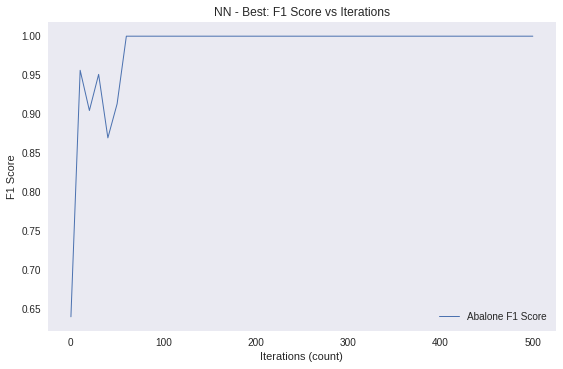

In [1]:
import numpy as np
from time import clock
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from google.colab import drive
drive.mount('/content/gdrive')
directory = '/content/gdrive/My Drive/'

import itertools
import logging
import os
import glob
import re

from collections import defaultdict
from functools import reduce
from pprint import pprint, pformat
from os.path import basename

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

input_path = directory + 'Output 1551514976.4481525/'
output_path = directory + 'Output 1551514976.4481525/images/'
to_process = {
    'FLIPFLOP': {
        'path': 'FLIPFLOP',
        'nn_curve': False,
        'multiple_trials': True
    },
    'TSP': {
        'path': 'TSP',
        'nn_curve': False,
        'multiple_trials': True
    },
    'CONTPEAKS': {
        'path': 'CONTPEAKS',
        'nn_curve': False,
        'multiple_trials': True
    },
    'NN': {
        'path': 'NN_OUTPUT',
        'nn_curve': True,
        'multiple_trials': False
    }
}

the_best = {}

# TODO: Drop the sd graphing? Might not add much to some graphs.... CONTPEAKS -SA is kind of a mess...


def plot_data(title, data, column_prefixes=None, validate_only=False, nn_curve=False, clear_existing=True,
              ylim=None, x_scale='linear', y_scale='linear', legend_name=None,
              x_label='Iterations (count)', y_label='Fitness'):

    if clear_existing:
        plt.close()
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.grid()
        plt.tight_layout()
        plt.gcf().subplots_adjust(bottom=0.15)

    ax = plt.gca()

    if x_scale is not None or y_scale is not None:
        if x_scale is not None:
            ax.set_xscale(x_scale)
        if y_scale is not None:
            ax.set_yscale(y_scale)

    if column_prefixes is not None:
        for i, column_prefix in enumerate(column_prefixes):
            if not nn_curve:
                mean = data['{}_mean'.format(column_prefix)]
                std = data['{}_std'.format(column_prefix)]

                plt.fill_between(data.index, mean - std,
                                 mean + std, alpha=0.2)
                plt.plot(data.index, mean, '-', linewidth=1, markersize=1,
                         label=column_prefix)
            else:
                train = data['{}_f1_trg'.format(column_prefix)]
                test = data['{}_f1_tst'.format(column_prefix)]
                val = data['{}_f1_val'.format(column_prefix)]
                if not validate_only:
                    plt.plot(data.index, train, '-', linewidth=1, markersize=1,
                             label='Train {} {}'.format(column_prefix, y_label))
                    plt.plot(data.index, val, '-', linewidth=1, markersize=1,
                             label='CV {} {}'.format(column_prefix, y_label))
                else:
                    plt.plot(data.index, test, '-', linewidth=1, markersize=1,
                             label='{} {}'.format(column_prefix, y_label))

    else:
        if not nn_curve:
            mean = data['mean']
            std = data['std']
            plt.fill_between(data.index, mean - std,
                             mean + std, alpha=0.2)
            plt.plot(data.index, mean, '-', linewidth=1, markersize=1, label=None)
        else:
            train = data['f1_trg']
            val = data['f1_val']
            plt.plot(data.index, train, '-', linewidth=1, markersize=1,
                     label='Train {}'.format(y_label))
            plt.plot(data.index, val, '-', linewidth=1, markersize=1,
                     label='CV {}'.format(y_label))

    plt.legend(title=legend_name, loc="best")
    return plt


def read_data_file(file, nn_curve=False):
    logger.info("    - Processing {}".format(file))
    df = pd.read_csv(file, header=None)
    if nn_curve:
        df.columns = ['iteration', 'MSE_trg', 'MSE_val', 'MSE_tst', 'acc_trg','acc_val', 'acc_tst', 'f1_trg', 'f1_val', 'f1_tst','elapsed']
    else:
        df.columns = ['iterations', 'fitness', 'time', 'fevals']
    if 'iterations' not in df.columns:
        df = df.rename(columns={'iteration': 'iterations'})

    df = df.set_index('iterations')
    # Trim the nn graphs to the first 1k iterations, as after that the graphs flatten out
    if nn_curve:
        df = df[df.index <= 2000]

    return df


def read_data_files(files, nn_curve=False, best_only=False):
    dfs = {}
    if isinstance(files, str):
        dfs[files] = read_data_file(files, nn_curve)
    else:
        if best_only:
            for file in files:
                dfs[file] = read_data_file(file, nn_curve)
        else:
            for f in files:
                file = files[f]
                dfs[f] = read_data_file(file, nn_curve)

    return dfs


def process_step_df(dfs, graph_ys, best_only=False):
    step_df = {}
    for y in graph_ys:
        step_df[y] = pd.DataFrame()
    for key, value in dfs.items():
        for y in graph_ys:
            step_df[y][key] = value[y]
    return step_df


def plot_mimic_data(problem_name, mimic_files, output_dir, nn_curve=False):
    graph_ys = ['fitness', 'time', 'fevals'] if not nn_curve else []
    logger.info("Plotting MIMIC data")

    y_label = 'F1 Score' if nn_curve else 'Fitness'

    if not os.path.exists('{}/{}'.format(output_dir, problem_name)):
        os.makedirs('{}/{}'.format(output_dir, problem_name))

    for samples in mimic_files.keys():
        logger.info(" - samples = {}".format(samples))
        for keep in mimic_files[samples].keys():
            logger.info("   - keep = {}".format(keep))

            main_df = {}
            for y in graph_ys:
                main_df[y] = pd.DataFrame()
            for m in mimic_files[samples][keep].keys():
                # Read the files into different dataframes
                dfs = read_data_files(mimic_files[samples][keep][m], nn_curve=nn_curve)
                step_df = process_step_df(dfs, graph_ys)

                for y in graph_ys:
                    df = step_df[y]
                    main_df[y]['{}_mean'.format(m)] = np.mean(df, axis=1)
                    main_df[y]['{}_std'.format(m)] = np.std(df, axis=1)

            if nn_curve:
                # For the NN problem convergence happens relatively early (except for SA)
                main_df = main_df[main_df.index <= 500]
                p = plot_data('{} - MIMIC {} {}: {} vs Iterations'.format(problem_name, samples, keep,
                                                                          y.capitalize()), main_df[y],
                              sorted(mimic_files[samples][keep].keys()),
                              legend_name='M', nn_curve=nn_curve,
                              y_label=y.capitalize())
                if not os.path.exists('{}/{}'.format(output_dir, problem_name)):
                    os.makedirs('{}/{}'.format(output_dir, problem_name))

                p.savefig(
                    '{}/{}/MIMIC_{}_{}_{}.png'.format(output_dir, problem_name, samples, keep, y.capitalize()),
                    format='png', dpi=150)
            else:
                for y in graph_ys:
                    p = plot_data('{} - MIMIC {} {}: {} vs Iterations'.format(problem_name, samples, keep,
                                                                              y.capitalize()), main_df[y],
                                  sorted(mimic_files[samples][keep].keys()),
                                  legend_name='M', nn_curve=nn_curve,
                                  y_label=y.capitalize())

                    p.savefig(
                        '{}/{}/MIMIC_{}_{}_{}.png'.format(output_dir, problem_name, samples, keep, y.capitalize()),
                        format='png', dpi=150)


def plot_ga_data(problem_name, ga_files, output_dir, nn_curve=False):
    graph_ys = ['fitness', 'time', 'fevals'] if not nn_curve else []
    logger.info("Plotting GA data")

    y_label = 'F1 Score' if nn_curve else 'Fitness'

    if not os.path.exists('{}/{}'.format(output_dir, problem_name)):
        os.makedirs('{}/{}'.format(output_dir, problem_name))

    for pop in ga_files.keys():
        logger.info(" - pop = {}".format(pop))
        mate_count = len(ga_files[pop].keys())
        for i, mate in enumerate(ga_files[pop].keys()):
            logger.info("   - mate = {}".format(mate))

            main_df = {}
            for y in graph_ys:
                main_df[y] = pd.DataFrame()
            for mutate in ga_files[pop][mate].keys():
                # Read the files into different dataframes
                dfs = read_data_files(ga_files[pop][mate][mutate], nn_curve=nn_curve)
                step_df = process_step_df(dfs, graph_ys)

                if nn_curve:
                    dfs = list(dfs.values())
                    if mate not in main_df:
                        main_df[mate] = []
                    for df in dfs:
                        df.columns = ['{}_{}'.format(mutate, str(col)) for col in df.columns]
                    main_df[mate].extend(dfs)
                else:
                    for y in graph_ys:
                        df = step_df[y]
                        main_df[y]['{}_mean'.format(mutate)] = np.mean(df, axis=1)
                        main_df[y]['{}_std'.format(mutate)] = np.std(df, axis=1)

            if nn_curve:
                # For the NN problem convergence happens relatively early (except for SA)
                main_df[mate] = reduce(lambda x, y: pd.merge(x, y, on='iterations'), main_df[mate])
                main_df[mate] = main_df[mate][main_df[mate].index <= 500]
                p = plot_data('{} - GA {} {}: {} vs Iterations'.format(problem_name, pop, mate,
                                                                       y_label), main_df[mate],
                              sorted(ga_files[pop][mate].keys()),
                              legend_name='Mutate', nn_curve=nn_curve,
                              y_label=y_label)
            else:
                for y in graph_ys:
                    p = plot_data('{} - GA {} {}: {} vs Iterations'.format(problem_name, pop, mate,
                                                                           y.capitalize()), main_df[y],
                                  sorted(ga_files[pop][mate].keys()),
                                  legend_name='Mutate', nn_curve=nn_curve,
                                  y_label=y.capitalize())

                    p.savefig(
                        '{}/{}/GA_{}_{}_{}.png'.format(output_dir, problem_name, pop, mate, y.capitalize()),
                        format='png', dpi=150)
        if nn_curve:
            p.savefig(
                '{}/{}/GA_{}_{}.png'.format(output_dir, problem_name, pop, 'Score'),
                format='png', dpi=150)


def plot_sa_data(problem_name, sa_files, output_dir, nn_curve=False):
    graph_ys = ['fitness', 'time', 'fevals'] if not nn_curve else []
    logger.info("Plotting SA data")

    y_label = 'F1 Score' if nn_curve else 'Fitness'

    if not os.path.exists('{}/{}'.format(output_dir, problem_name)):
        os.makedirs('{}/{}'.format(output_dir, problem_name))

    main_df = {}
    for y in graph_ys:
        main_df[y] = pd.DataFrame()
    for ce in sa_files.keys():
        # Read the files into different dataframes
        dfs = read_data_files(sa_files[ce], nn_curve=nn_curve)
        step_df = process_step_df(dfs, graph_ys)

        if nn_curve:
            dfs = list(dfs.values())
            for df in dfs:
                df.columns = ['{}_{}'.format(ce, str(col)) for col in df.columns]
            main_df[ce] = dfs
        else:
            for y in graph_ys:
                df = step_df[y]
                main_df[y]['{}_mean'.format(ce)] = np.mean(df, axis=1)
                main_df[y]['{}_std'.format(ce)] = np.std(df, axis=1)

    if nn_curve:
        main_df = list(map(lambda x: x[0], list(main_df.values())))
        main_df = reduce(lambda x, y: pd.merge(x, y, on='iterations'), main_df)
        p = plot_data('{} - SA: {} vs Iterations'.format(problem_name, y_label), main_df,
                      sorted(sa_files.keys()),
                      legend_name='CE', nn_curve=nn_curve,
                      y_label=y_label)

        p.savefig(
            '{}/{}/SA_{}.png'.format(output_dir, problem_name, 'Accuracy'),
            format='png', dpi=150)
    else:
        for y in graph_ys:
            p = plot_data('{} - SA: {} vs Iterations'.format(problem_name, y.capitalize()), main_df[y],
                          sorted(sa_files.keys()),
                          legend_name='CE', nn_curve=nn_curve,
                          y_label=y.capitalize())

            p.savefig(
                '{}/{}/SA_{}.png'.format(output_dir, problem_name, y.capitalize()),
                format='png', dpi=150)


def plot_rhc_data(problem_name, rhc_files, output_dir, nn_curve=False):
    graph_ys = ['fitness', 'time', 'fevals'] if not nn_curve else []
    logger.info("Plotting RHC data")

    y_label = 'F1 Score' if nn_curve else 'Fitness'

    if not os.path.exists('{}/{}'.format(output_dir, problem_name)):
        os.makedirs('{}/{}'.format(output_dir, problem_name))

    main_df = {}
    for y in graph_ys:
        main_df[y] = pd.DataFrame()
    # Read the files into different dataframes
    dfs = read_data_files(rhc_files, nn_curve=nn_curve)
    step_df = process_step_df(dfs, graph_ys)

    if nn_curve:
        dfs = list(dfs.values())
        main_df = dfs[0]
    else:
        for y in graph_ys:
            df = step_df[y]
            main_df[y]['mean'] = np.mean(df, axis=1)
            main_df[y]['std'] = np.std(df, axis=1)

    if nn_curve:
        # For the NN problem convergence happens relatively early (except for SA)
        main_df = main_df[main_df.index <= 500]
        p = plot_data('{} - RHC: {} vs Iterations'.format(problem_name, y_label), main_df,
                      None, nn_curve=nn_curve,
                      y_label=y_label)

        p.savefig(
            '{}/{}/RHC_{}.png'.format(output_dir, problem_name, 'Fitness'),
            format='png', dpi=150)
    else:
        for y in graph_ys:
            p = plot_data('{} - RHC: {} vs Iterations'.format(problem_name, y.capitalize()), main_df[y],
                          None, nn_curve=nn_curve,
                          y_label=y.capitalize())

            p.savefig(
                '{}/{}/RHC_{}.png'.format(output_dir, problem_name, y.capitalize()),
                format='png', dpi=150)


def plot_backprop_data(problem_name, backprop_files, output_dir, nn_curve=False):
    graph_ys = ['fitness', 'time', 'fevals'] if not nn_curve else []
    logger.info("Plotting Backprop data")

    y_label = 'F1 Score' if nn_curve else 'Fitness'

    if not os.path.exists('{}/{}'.format(output_dir, problem_name)):
        os.makedirs('{}/{}'.format(output_dir, problem_name))

    main_df = {}
    for y in graph_ys:
        main_df[y] = pd.DataFrame()
    # Read the files into different dataframes
    dfs = read_data_files(backprop_files, nn_curve=nn_curve)
    step_df = process_step_df(dfs, graph_ys)

    if nn_curve:
        dfs = list(dfs.values())
        main_df = dfs[0]
    else:
        for y in graph_ys:
            df = step_df[y]
            main_df[y]['mean'] = np.mean(df, axis=1)
            main_df[y]['std'] = np.std(df, axis=1)

    if nn_curve:
        # For the NN problem convergence happens relatively early (except for SA)
        main_df = main_df[main_df.index <= 500]
        p = plot_data('{} - Backprop: {} vs Iterations'.format(problem_name, y_label), main_df,
                      None, nn_curve=nn_curve,
                      y_label=y_label)
        p.savefig(
            '{}/{}/Backprop_{}.png'.format(output_dir, problem_name, 'Fitness'),
            format='png', dpi=150)
    else:
        for y in graph_ys:
            p = plot_data('{} - Backprop: {} vs Iterations'.format(problem_name, y.capitalize()), main_df[y],
                          None, nn_curve=nn_curve,
                          y_label=y.capitalize())
            p.savefig(
                '{}/{}/Backprop_{}.png'.format(output_dir, problem_name, y.capitalize()),
                format='png', dpi=150)


def plot_best_curves(problem_name, files, output_dir, nn_curve=False):
    graph_ys = ['fitness', 'time', 'fevals'] if not nn_curve else []
    logger.info("Plotting best results for {}".format(problem_name))

    y_label = 'F1 Score' if nn_curve else 'Fitness'

    if not os.path.exists('{}/{}'.format(output_dir, problem_name)):
        os.makedirs('{}/{}'.format(output_dir, problem_name))

    output_file_name_regex = re.compile('{}_([A-Za-z]+)(.*)_LOG\.csv'.format(problem_name))
    prefixes = []
    for algo in files:
        file = files[algo][0]
        base_file_name = basename(file)
        algo, _ = output_file_name_regex.search(base_file_name).groups()
        prefixes.append(algo)
    prefixes.sort()

    main_df = {}
    for y in graph_ys:
        main_df[y] = pd.DataFrame()

    for algo in files:
        dfs = read_data_files(files[algo], nn_curve=nn_curve, best_only=True)
        step_df = process_step_df(dfs, graph_ys)

        if nn_curve:
            df = list(dfs.values())[0]
            df.columns = ['{}_{}'.format(algo, str(col)) for col in df.columns]
            main_df[algo] = dfs
        else:
            for y in graph_ys:
                df = step_df[y]
                main_df[y]['{}_mean'.format(algo)] = np.mean(df, axis=1)
                main_df[y]['{}_std'.format(algo)] = np.std(df, axis=1)

    if nn_curve:
        main_df = list(main_df.values())
        main_df = [list(k.values())[0] for k in main_df]
        main_df = reduce(lambda x, y: pd.merge(x, y, on='iterations'), main_df)
        # For the NN problem convergence happens relatively early (except for SA)
        main_df = main_df[main_df.index <= 500]
    else:
        p = plot_data('{} - Best: {} vs Iterations'.format(problem_name, 'Function Evals'), main_df['fevals'],
                      prefixes, nn_curve=nn_curve, validate_only=nn_curve,
                      y_label=y_label)
        p.savefig(
            '{}/{}/Best_{}.png'.format(output_dir, problem_name, 'Fevals'),
            format='png', dpi=150)

        p = plot_data('{} - Best: {} vs Iterations'.format(problem_name, 'Time'), main_df['time'],
                          prefixes, nn_curve=nn_curve, validate_only=nn_curve,
                          y_label='Time')
        p.yscale('log')
        p.savefig(
            '{}/{}/Best_{}.png'.format(output_dir, problem_name, 'Time'),
            format='png', dpi=150)

        main_df = main_df['fitness']

    p = plot_data('{} - Best: {} vs Iterations'.format(problem_name, y_label), main_df,
                  prefixes, nn_curve=nn_curve, validate_only=nn_curve,
                  y_label=y_label)
    p.savefig(
        '{}/{}/Best_{}.png'.format(output_dir, problem_name, 'Fitness'),
        format='png', dpi=150)
    


def read_and_plot_test_output(base_dir, output_dir, problem_name, multiple_trials=True, nn_curve=False):
    logger.info("Reading {} data".format(problem_name))
    output_file_name_regex = re.compile('{}_([A-Za-z]+)(.*)_LOG\.csv'.format(problem_name))
    output_files = glob.glob('{}/{}_*_LOG.csv'.format(base_dir, problem_name))
    files = defaultdict(dict)
    for output_file in output_files:
        base_file_name = basename(output_file)
        algo, params = output_file_name_regex.search(base_file_name).groups()
        params = list(filter(None, params.split('_')))

        # Processing based on algorithm
        if algo == 'MIMIC':
            if multiple_trials:
                samples, keep, m, trial = params
            else:
                samples, keep, m = params

            if samples not in files[algo]:
                files[algo][samples] = {}
            if keep not in files[algo][samples]:
                files[algo][samples][keep] = {}
            if m not in files[algo][samples][keep]:
                files[algo][samples][keep][m] = {}
            if multiple_trials:
                if trial not in files[algo][samples][keep][m]:
                    files[algo][samples][keep][m][trial] = {}

                files[algo][samples][keep][m][trial] = output_file
            else:
                files[algo][samples][keep][m] = output_file

        elif algo == 'RHC':
            if multiple_trials:
                files[algo][params[0]] = output_file
            else:
                files[algo][1] = output_file

        elif algo == 'Backprop':
            if multiple_trials:
                files[algo][params[0]] = output_file
            else:
                files[algo][1] = output_file

        elif algo == 'SA':
            if multiple_trials:
                ce, trial = params
            else:
                ce = params[0]

            if ce not in files[algo]:
                files[algo][ce] = {}
            if multiple_trials:
                if trial not in files[algo][ce]:
                    files[algo][ce][trial] = {}

                files[algo][ce][trial] = output_file
            else:
                files[algo][ce] = output_file

        elif algo == 'GA':
            if multiple_trials:
                pop, mate, mutate, trial = params
            else:
                pop, mate, mutate = params

            if pop not in files[algo]:
                files[algo][pop] = {}
            if mate not in files[algo][pop]:
                files[algo][pop][mate] = {}
            if mutate not in files[algo][pop][mate]:
                files[algo][pop][mate][mutate] = {}

            if multiple_trials:
                if trial not in files[algo][pop][mate][mutate]:
                    files[algo][pop][mate][mutate][trial] = {}

                files[algo][pop][mate][mutate][trial] = output_file
            else:
                files[algo][pop][mate][mutate] = output_file

    if 'MIMIC' in files:
        plot_mimic_data(problem_name, files['MIMIC'], output_dir, nn_curve=nn_curve),
    if 'GA' in files:
        plot_ga_data(problem_name, files['GA'], output_dir, nn_curve=nn_curve)
    if 'SA' in files:
        plot_sa_data(problem_name, files['SA'], output_dir, nn_curve=nn_curve)
    if 'Backprop' in files:
        plot_backprop_data(problem_name, files['Backprop'], output_dir, nn_curve=nn_curve)
    if 'RHC' in files:
        plot_rhc_data(problem_name, files['RHC'], output_dir, nn_curve=nn_curve)


def find_best_results(base_dir, problem_name, nn_curve=False, multiple_trials=False):
    output_file_name_regex = re.compile('{}_([A-Za-z]+)(.*)_LOG\.csv'.format(problem_name))
    output_files = glob.glob('{}/{}_*_LOG.csv'.format(base_dir, problem_name))
    files = {}
    for output_file in output_files:
        base_file_name = basename(output_file)
        algo, params = output_file_name_regex.search(base_file_name).groups()
        params = list(filter(None, params.split('_')))

        if algo not in files:
            files[algo] = {'files': [], 'best': 0}

        df = read_data_file(output_file, nn_curve=nn_curve)
        if nn_curve:
            best_value = np.max(np.max(df[['f1_tst']]))
        else:
            best_value = np.max(df['fitness'])

        if best_value > files[algo]['best']:
            if nn_curve:
                files[algo]['best'] = best_value
                files[algo]['files'] = [output_file]
            else:
                # Read all the trials for this algo and param set
                params = '_'.join(params[0:-1])
                similar_files = glob.glob('{}/{}_{}{}*_LOG.csv'.format(base_dir, problem_name, algo, params))

                # TODO: This is super inefficient ... but... maybe fine? ¯\_(ツ)_/¯
                # Double-check it's still the best
                fitness_data = df['fitness']
                for i, f in enumerate(list(similar_files)):
                    file_fitness_data = read_data_file(f, nn_curve=nn_curve)[['fitness']]
                    fitness_data = pd.concat([fitness_data, file_fitness_data], axis=1)

                curr_max = np.max(np.mean(fitness_data, axis=1))
                if curr_max > files[algo]['best']:
                    files[algo]['best'] = curr_max
                    files[algo]['files'] = list(similar_files)

    logger.info(pformat(files))
    with open(input_path + '/best_results_raw.txt', 'a+') as f:
        f.write("---------- {} ----------\n".format(problem_name))
        f.write(pformat(files) + '\n')

    return dict(list(map(lambda k: (k, files[k]['files']), files)))


if __name__ == '__main__':
    for problem_name in to_process:
        logger.info("Processing {}".format(problem_name))
        problem = to_process[problem_name]
        read_and_plot_test_output('{}/{}'.format(input_path, problem['path']),
                                  output_path, problem_name, nn_curve=problem['nn_curve'],
                                  multiple_trials=problem['multiple_trials'])
        best_files = find_best_results('{}/{}'.format(input_path, problem['path']), problem_name,
                                       nn_curve=problem['nn_curve'], multiple_trials=problem['multiple_trials'])
        the_best[problem_name] = best_files
        plot_best_curves(problem_name, best_files, output_path, nn_curve=problem['nn_curve'])

    # TODO: This is wrong, right? Doesn't take into account the averaging of values?
    with open(input_path + '/best_results.csv', 'w+') as f:
        f.write('problem,algorithm,params,best fitness,best iterations,best time,best fevals\n')
        for problem_name in sorted(the_best):
            output_file_name_regex = re.compile('{}_([A-Za-z]+)(.*)_LOG\.csv'.format(problem_name))
            nn_curve = 'NN_' in problem_name
            best_files = the_best[problem_name]
            for algo in best_files:
                file = best_files[algo][0]
                _, params = output_file_name_regex.search(file).groups()
                params = list(filter(None, params[0:-1].split('_')))
                best_value = 0
                best_time = 0
                best_iterations = 0
                best_fevals = 0

                if problem_name == "NN":
                    nn_curve = True
                df = read_data_file(file, nn_curve=nn_curve)
                if nn_curve:
                    df = df[df.index <= 500]

                if nn_curve:
                    max_index = df['f1_tst'].idxmax()
                    best = df.ix[max_index]
                    best_iterations = max_index
                    best_value = best['f1_tst']
                    best_time = best['elapsed']
                else:
                    max_index = df['fitness'].idxmax()
                    best = df.ix[max_index]
                    best_iterations = max_index
                    best_value = best['fitness']
                    best_time = best['time']
                    best_fevals = best['fevals']

                f.write('{},{},"{}",{},{},{},{}\n'.format(problem_name, algo, params, best_value, best_iterations,
                                                       best_time, best_fevals))


In [2]:
def read_nn(filename, name):
  ab = pd.read_csv(input_path +"NN_OUTPUT/"+filename, header = None)
  ab.columns = ["iteration", "MSE_trg", "MSE_val", "MSE_tst", "acc_trg", "acc_val", "acc_tst", "f1_trg", "f1_val", "f1_tst", "times"]
  ab["type"] = name
  #print(ab.shape)
  return ab

ab_rhc = read_nn("NN_Abalone_RHC_LOG.csv", "RHC")

ab = ab_rhc.copy()

ab_bp = read_nn("NN_Abalone_Backprop_LOG.csv", "BP")

ab = ab.append(ab_bp)


ab_sa_07 = read_nn("NN_Abalone_SA_0.7_LOG.csv", "SA_0.7")
ab = ab.append(ab_sa_07)

ab_sa_015 = read_nn("NN_Abalone_SA_0.15_LOG.csv", "SA_0.15")
ab = ab.append(ab_sa_015)

ab_sa_035 = read_nn("NN_Abalone_SA_0.35_LOG.csv", "SA_0.35")
ab = ab.append(ab_sa_035)

ab_sa_055 = read_nn("NN_Abalone_SA_0.55_LOG.csv", "SA_0.55")
ab = ab.append(ab_sa_055)

ab_sa_095 = read_nn("NN_Abalone_SA_0.95_LOG.csv", "SA_0.95")
ab = ab.append(ab_sa_095)

ab_ga_10_10 = read_nn("NN_Abalone_GA_50_10_10_LOG.csv", "GA_10_10")
ab = ab.append(ab_ga_10_10)

ab_ga_10_20 = read_nn("NN_Abalone_GA_50_10_20_LOG.csv", "GA_10_20")
ab = ab.append(ab_ga_10_20)

ab_ga_20_10 = read_nn("NN_Abalone_GA_50_20_10_LOG.csv", "GA_20_10")
ab = ab.append(ab_ga_20_10)

ab_ga_20_20 = read_nn("NN_Abalone_GA_50_20_20_LOG.csv", "GA_20_20")
ab = ab.append(ab_ga_20_20)


# print(ab.shape)

ab



,iteration,MSE_trg,MSE_val,MSE_tst,acc_trg,acc_val,acc_tst,f1_trg,f1_val,f1_tst,times,type
0,0,1.830326e-01,1.816368e-01,0.188145,0.446725,0.442417,0.435754,0.617568,0.613439,0.607004,0.000938,RHC
1,10,1.708630e-01,1.621909e-01,0.170730,0.551320,0.590650,0.567438,0.710775,0.742652,0.724033,0.007007,RHC
2,20,1.730545e-01,1.636489e-01,0.173108,0.521017,0.562144,0.529130,0.685090,0.719708,0.692067,0.011893,RHC
3,30,1.750578e-01,1.661416e-01,0.175196,0.551320,0.584949,0.562650,0.710775,0.738129,0.720123,0.017561,RHC
4,40,1.703056e-01,1.619875e-01,0.170666,0.578690,0.616876,0.594573,0.733127,0.763047,0.745746,0.023009,RHC
5,50,1.706483e-01,1.622507e-01,0.171029,0.574291,0.606613,0.585794,0.729587,0.755145,0.738802,0.029299,RHC
6,60,2.055060e-01,1.972389e-01,0.205845,0.278592,0.288483,0.281724,0.435780,0.447788,0.439601,0.048495,RHC
7,70,1.695950e-01,1.616649e-01,0.170247,0.623656,0.656784,0.626496,0.768212,0.792842,0.770363,0.052753,RHC
8,80,1.699218e-01,1.613790e-01,0.170120,0.614858,0.647662,0.620910,0.761501,0.786159,0.766125,0.057314,RHC
9,90,1.715786e-01,1.628306e-01,0.170968,0.434018,0.472064,0.444533,0.605317,0.641363,0.615470,0.061602,RHC


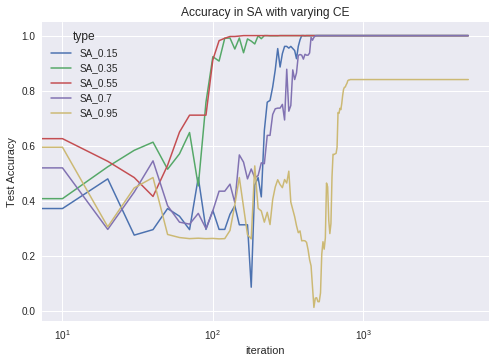

In [3]:
ab_sa = ab[ab.type.str.contains("SA")]

ab_sa.shape

ab_sa.head()

ab_sa = ab_sa.pivot(index='iteration', columns='type', values='acc_tst')

ax = ab_sa.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Test Accuracy', title = "Accuracy in SA with varying CE")
plt.show()



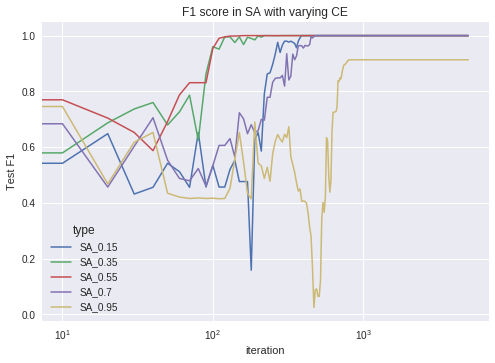

In [4]:
ab_sa = ab[ab.type.str.contains("SA")]

ab_sa.shape

ab_sa.head()

ab_sa = ab_sa.pivot(index='iteration', columns='type', values='f1_tst')

ax = ab_sa.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Test F1', title = "F1 score in SA with varying CE")
plt.show()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


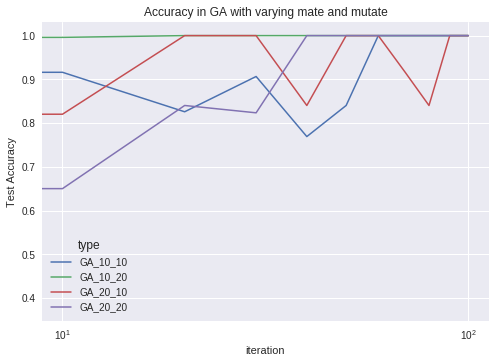

In [5]:
ab_ga = ab[ab.type.str.contains("GA")]

ab_ga.shape

ab_ga.head()

ab_ga.drop(ab_ga[ab_ga.iteration > 100].index, inplace = True)


ab_ga = ab_ga.pivot(index='iteration', columns='type', values='acc_tst')

ax = ab_ga.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Test Accuracy', title = "Accuracy in GA with varying mate and mutate")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


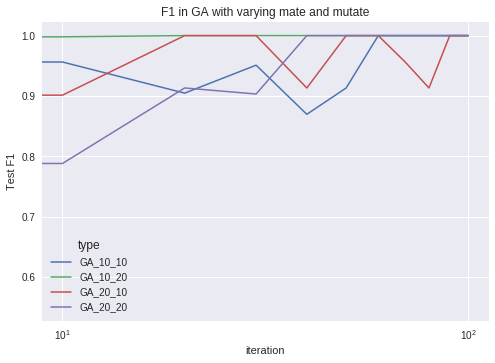

In [6]:
ab_ga = ab[ab.type.str.contains("GA")]

ab_ga.shape

ab_ga.head()

ab_ga.drop(ab_ga[ab_ga.iteration > 100].index, inplace = True)

ab_ga = ab_ga.pivot(index='iteration', columns='type', values='f1_tst')



ax = ab_ga.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Test F1', title = "F1 in GA with varying mate and mutate")
plt.show()

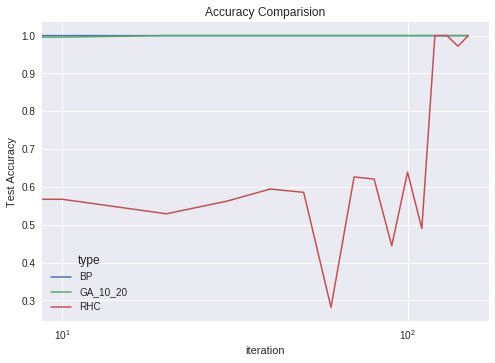

In [7]:
ab_ga = ab[ab.type.str.contains("GA_10_20")]

ab_sa = ab[ab.type.str.contains("SA_055")]

ab1 = ab_rhc.copy()
ab1 = ab1.append(ab_ga)
ab1 = ab1.append(ab_sa)
ab1 = ab1.append(ab_bp)


ab1.drop(ab1[ab1.iteration > 150].index, inplace=True)

ab1 = ab1.pivot(index='iteration', columns='type', values='acc_tst')

ax = ab1.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Test Accuracy', title = "Accuracy Comparision")
plt.show()

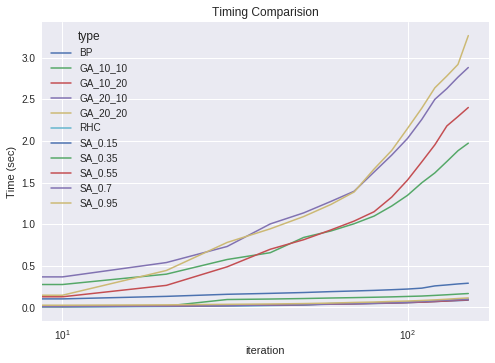

In [8]:
# ab_ga = ab[ab.type.str.contains("GA_10_20")]

# ab_sa = ab[ab.type.str.contains("SA_055")]

# ab1 = ab_rhc.copy()
# ab1 = ab1.append(ab_ga)
# ab1 = ab1.append(ab_sa)
# ab1 = ab1.append(ab_bp)


ab1 = ab.drop(ab[ab.iteration > 150].index)

ab1 = ab1.pivot(index='iteration', columns='type', values='times')

#ab1

ax = ab1.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Time (sec)', title = "Timing Comparision")
plt.show()

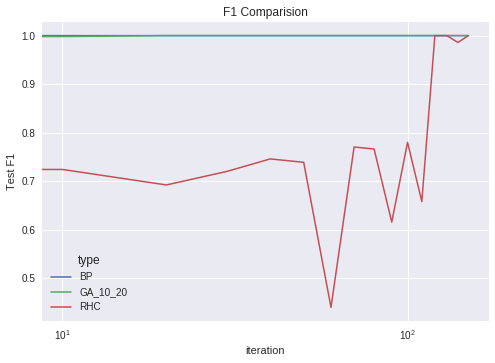

In [9]:
ab_ga = ab[ab.type.str.contains("GA_10_20")]

ab_sa = ab[ab.type.str.contains("SA_055")]

ab1 = ab_rhc.copy()
ab1 = ab1.append(ab_ga)
ab1 = ab1.append(ab_sa)
ab1 = ab1.append(ab_bp)


ab1.drop(ab1[ab1.iteration > 150].index, inplace=True)

ab1 = ab1.pivot(index='iteration', columns='type', values='f1_tst')

ax = ab1.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Test F1', title = "F1 Comparision")
plt.show()

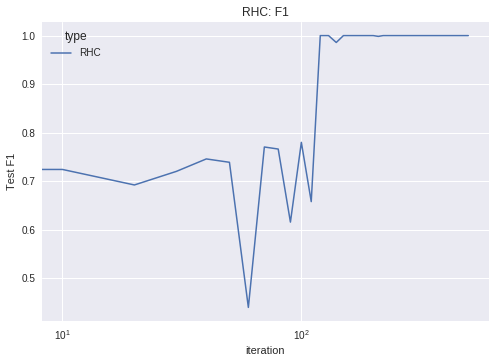

In [10]:

ab1 = ab_rhc.copy()


ab1.drop(ab1[ab1.iteration > 500].index, inplace=True)

ab1 = ab1.pivot(index='iteration', columns='type', values='f1_tst')

ax = ab1.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Test F1', title = "RHC: F1")
plt.show()

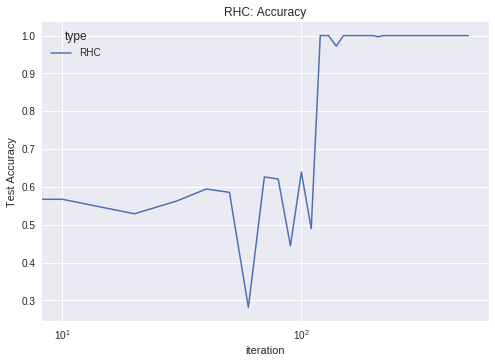

In [11]:

ab1 = ab_rhc.copy()


ab1.drop(ab1[ab1.iteration > 500].index, inplace=True)

ab1 = ab1.pivot(index='iteration', columns='type', values='acc_tst')

ax = ab1.plot(linewidth=1.5, logx = True)
ax.set(ylabel='Test Accuracy', title = "RHC: Accuracy")
plt.show()